In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 6]
from datetime import datetime
from sklearn.preprocessing import StandardScaler

/home/ben/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
prices = pd.read_pickle("close_prices_cleaned.pkl")

prices = prices.resample("H").mean() # changed from last to mean
aud_cols = [i for i in prices.columns if "AUD" in i]

prices = prices[aud_cols]
#prices = prices[["AUDJPY", "USDCAD"]]

# flat prices from april - June 2016 - remove
prices = prices.loc[:datetime(2016, 4, 1, 0, 0, 0)]
returns = prices.pct_change()
standardized_prices = returns.cumsum()

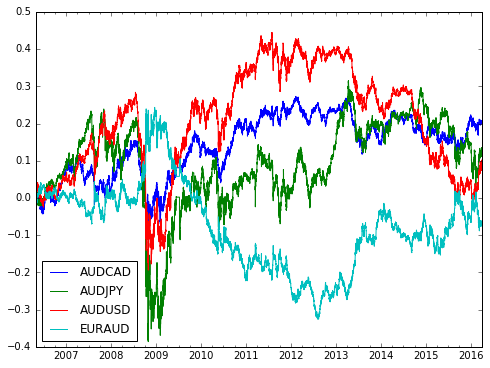

In [3]:
standardized_prices.iloc[10:].plot()
#plt.plt()

In [4]:
def rolling_z_score(df, halflife, z_cap=2.0):
    rm = pd.ewma(df, halflife=halflife)
    std = pd.ewmstd(df, halflife=halflife)
    z = (df -  rm ) / std
    z.columns = [i + 'z' + str(halflife) for i in z.columns]
    z[z > z_cap] = z_cap
    z[z < -1.0 * z_cap] = -1.0 * z_cap
    return z

In [5]:
def calc_trend(prices, ma_period, shift=0):
    #ma = pd.rolling_mean(prices, ma_period)
    ma = prices.rolling(window=ma_period, center=False).mean()
    trend = prices.applymap(np.log) - ma.applymap(np.log)
    trend.columns = [i + "_" + str(ma_period) + "_" + str(shift) for i in trend.columns]
    trend = trend.shift(shift).fillna(method='ffill')
    return trend

In [6]:
returns = prices.pct_change().fillna(0)
halflives = [1, 2, 3, 4, 6, 8, 14, 16]

feature_list = []

for hl in halflives:
    feature_list.append(rolling_z_score(returns, halflife=hl))
        
z_scores = pd.concat(feature_list, axis=1)

/home/ben/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=1,ignore_na=False,min_periods=0,adjust=True).mean()
  from ipykernel import kernelapp as app
/home/ben/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=1,ignore_na=False,min_periods=0,adjust=True).std(bias=False)
  app.launch_new_instance()
/home/ben/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=2,ignore_na=False,min_periods=0,adjust=True).mean()
  from ipykernel import kernelapp as app
/home/ben/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_std is depreca

In [7]:
scaler = StandardScaler()
scaled_prices = pd.DataFrame(scaler.fit_transform(prices), columns=prices.columns, index=prices.index)

from sklearn.decomposition import PCA

pca = PCA(n_components=None)
pca.fit(z_scores.fillna(0))
z_pca = pca.transform(z_scores.fillna(0))

[ 0.66922892  0.79714268  0.905134    0.96676393  0.98449111  0.98868835
  0.99241563  0.99488826  0.99719071  0.99795243  0.99864598  0.99911287
  0.99947945  0.99960743  0.99973032  0.99982318  0.99988069  0.99990716
  0.99993239  0.99995148  0.99996459  0.9999714   0.99997752  0.99998292
  0.99998705  0.99998945  0.99999163  0.99999376  0.99999555  0.99999717
  0.99999861  1.        ]


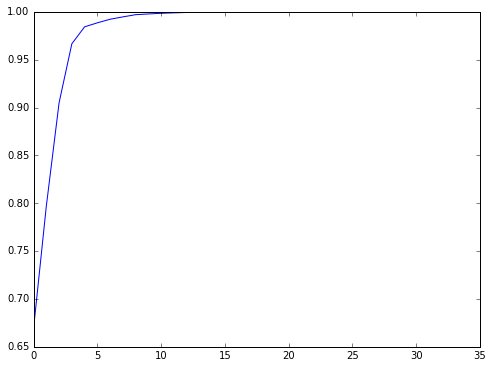

In [8]:
cum_var_expl = pca.explained_variance_ratio_.cumsum()
print cum_var_expl

plt.plot(cum_var_expl)

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(z_scores.fillna(0), returns.shift(-1).fillna(0))

In [12]:
rgr = LinearRegression()
rgr.fit(x_train, y_train)
preds_is = rgr.predict(x_train)
preds_os = rgr.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score
print mean_squared_error(y_train, preds_is)
print r2_score(y_train, preds_is)

1.56321488265e-06
0.0382968034092


/home/ben/anaconda/lib/python2.7/site-packages/sklearn/metrics/regression.py:471: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value, it will be changed to 'uniform_average' in 0.18.
  DeprecationWarning)


In [13]:
print mean_squared_error(y_test, preds_os)
print r2_score(y_test, preds_os)

1.67758156915e-06
0.0342250724721


/home/ben/anaconda/lib/python2.7/site-packages/sklearn/metrics/regression.py:471: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value, it will be changed to 'uniform_average' in 0.18.
  DeprecationWarning)


In [16]:
# now try linear regression
x_train_vals = x_train.astype(np.float32).values
y_train_vals = y_train.astype(np.float32).values

x_test_vals = x_test.astype(np.float32).values
y_test_vals = y_test.astype(np.float32).values

X = tf.placeholder("float")
y = tf.placeholder("float")

num_inputs = x_train.shape[1]
num_outs = y_train.shape[1]

print num_inputs, num_outs

W = tf.Variable(tf.truncated_normal([num_inputs, num_outs], stddev = 1.0/np.sqrt(num_inputs), name="weight"))
b = tf.Variable(tf.truncated_normal([num_outs,], stddev = 1e-4, name="bias"))

y_model = tf.add(tf.matmul(X, W), b)

loss = tf.reduce_mean(tf.square(y - y_model) * 1e4)
#loss = tf.reduce_sum(tf.pow(y - y_train_vals, 2)) 
#loss_p = tf.Print(loss, [loss], "loss: ")
optimizer = tf.train.GradientDescentOptimizer(0.00001).minimize(loss)
#optimizer = tf.train.AdamOptimizer(0.00001).minimize(loss)
init = tf.initialize_all_variables()
#train = optimizer.minimize(loss)

32 4


In [17]:
with tf.Session() as sess:
    sess.run(init)
    
    rolling_test_loss = 1.0e9
    disp_step = 1000
    
    for i in range(30000):
        sess.run(optimizer, feed_dict={X : x_train_vals, y : y_train_vals})
        
        if i % disp_step == 0:
            
            this_test_loss = sess.run(loss, feed_dict={X:x_test_vals, y:y_test_vals})
            
            print "Training iteration:", '%04d' % (i + 1), "cost=", "{:.9f}"\
            .format(sess.run(loss, feed_dict={X:x_train_vals, y:y_train_vals}))
            
            print "Testing iteration:", '%04d' % (i + 1), "cost=", "{:.9f}"\
            .format(this_test_loss)     
            
            if rolling_test_loss < this_test_loss * 1.005:
                break # has converged
                
            rolling_test_loss = this_test_loss
           
    #w_mod = W_1.eval()
    #b_mod = b_1.eval()
    
    y_is = y_model.eval(feed_dict={X:x_train_vals, y:y_train_vals})
    y_os = y_model.eval(feed_dict={X:x_test_vals, y:y_test_vals})
    

Training iteration: 0001 cost= 1275.524902344
Testing iteration: 0001 cost= 1282.289672852
Training iteration: 1001 cost= 6.301959038
Testing iteration: 1001 cost= 6.350444794
Training iteration: 2001 cost= 3.190639257
Testing iteration: 2001 cost= 3.220044374
Training iteration: 3001 cost= 1.976895690
Testing iteration: 3001 cost= 1.999745250
Training iteration: 4001 cost= 1.405848265
Testing iteration: 4001 cost= 1.428489447
Training iteration: 5001 cost= 1.100320339
Testing iteration: 5001 cost= 1.125084281
Training iteration: 6001 cost= 0.916972399
Testing iteration: 6001 cost= 0.944456995
Training iteration: 7001 cost= 0.795774162
Testing iteration: 7001 cost= 0.825886309
Training iteration: 8001 cost= 0.709242761
Testing iteration: 8001 cost= 0.741616488
Training iteration: 9001 cost= 0.643663943
Testing iteration: 9001 cost= 0.677866995
Training iteration: 10001 cost= 0.591674387
Testing iteration: 10001 cost= 0.627308905
Training iteration: 11001 cost= 0.549068093
Testing itera

NameError: name 'W_1' is not defined

In [42]:
# now try linear regression
x_train_vals = x_train.astype(np.float32).values
y_train_vals = y_train.astype(np.float32).values

x_test_vals = x_test.astype(np.float32).values
y_test_vals = y_test.astype(np.float32).values


num_hidden_1 = 50
#num_hidden_2 = 20

X = tf.placeholder("float")
y = tf.placeholder("float")

num_inputs = x_train.shape[1]
num_outs = y_train.shape[1]

print num_inputs, num_outs

W_1 = tf.Variable(tf.random_normal([num_inputs, num_hidden_1], stddev = 1.0/np.sqrt(num_inputs), name="weight1"))
W_2 = tf.Variable(tf.random_normal([num_hidden_1, num_outs], stddev = 1.0/np.sqrt(num_hidden_1), name="weight2"))
b_1 = tf.Variable(tf.random_normal([num_hidden_1,], stddev = 1.0/np.sqrt(num_inputs), name="bias1"))
b_2 = tf.Variable(tf.random_normal([num_outs,], stddev = 1.0/np.sqrt(num_inputs), name="bias2"))

hidden = tf.nn.relu(tf.add(tf.matmul(X, W_1), b_1))
#hidden = tf.add(tf.matmul(X, W_1), b_1)
hidden = tf.nn.dropout(hidden, keep_prob=0.75)

y_model = tf.add(tf.matmul(hidden, W_2), b_2)

loss = tf.reduce_mean(tf.square(y - y_model) * 1e4)
#optimizer = tf.train.GradientDescentOptimizer(0.00001).minimize(loss)
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
init = tf.initialize_all_variables()
#train = optimizer.minimize(loss)

32 4


In [43]:
with tf.Session() as sess:
    sess.run(init)
    
    rolling_test_loss = 1.0e9
    disp_step = 1000
    
    for i in range(30000):
        sess.run(optimizer, feed_dict={X : x_train_vals, y : y_train_vals})
        
        if i % disp_step == 0:
            
            this_test_loss = sess.run(loss, feed_dict={X:x_test_vals, y:y_test_vals})
            
            print "Training iteration:", '%04d' % (i + 1), "cost=", "{:.9f}"\
            .format(sess.run(loss, feed_dict={X:x_train_vals, y:y_train_vals}))
            
            print "Testing iteration:", '%04d' % (i + 1), "cost=", "{:.9f}"\
            .format(this_test_loss)     
            
            if rolling_test_loss < this_test_loss * 1.005:
                break # has converged
                
            rolling_test_loss = this_test_loss
           
    w_mod = W_1.eval()
    b_mod = b_1.eval()
    
    y_is = y_model.eval(feed_dict={X:x_train_vals, y:y_train_vals})
    y_os = y_model.eval(feed_dict={X:x_test_vals, y:y_test_vals})
    

Training iteration: 0001 cost= 2821.097167969
Testing iteration: 0001 cost= 2838.901367188
Training iteration: 1001 cost= 0.080961227
Testing iteration: 1001 cost= 0.099896081
Training iteration: 2001 cost= 0.027299136
Testing iteration: 2001 cost= 0.033420052
Training iteration: 3001 cost= 0.019986022
Testing iteration: 3001 cost= 0.025864854
Training iteration: 4001 cost= 0.017391833
Testing iteration: 4001 cost= 0.023155097
Training iteration: 5001 cost= 0.016727941
Testing iteration: 5001 cost= 0.020010073
Training iteration: 6001 cost= 0.016199268
Testing iteration: 6001 cost= 0.018932283
Training iteration: 7001 cost= 0.016105073
Testing iteration: 7001 cost= 0.020005785


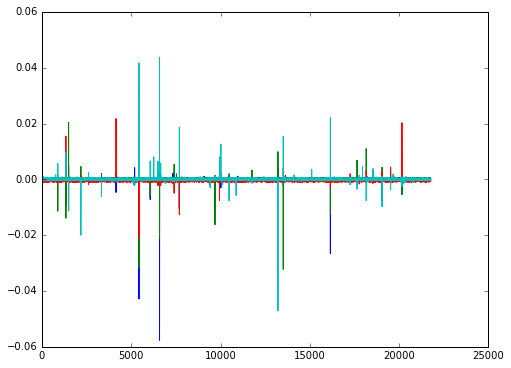

In [46]:
plt.plot(y_os)

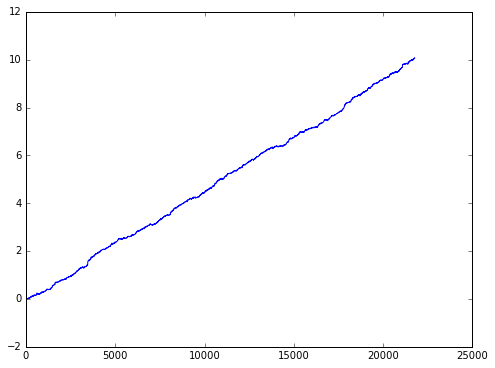

In [47]:
p_is = np.sign(y_is) * y_train_vals
p_os = np.sign(y_os) * y_test_vals
plt.plot(p_os.sum(axis=1).cumsum()) # was good when using 3 * std at initializer

In [23]:
# now try linear regression
x_train_vals = x_train.astype(np.float32).values
y_train_vals = y_train.astype(np.float32).values

x_test_vals = x_test.astype(np.float32).values
y_test_vals = y_test.astype(np.float32).values


num_hidden_1 = 40
num_hidden_2 = 20

X = tf.placeholder("float")
y = tf.placeholder("float")

num_inputs = x_train.shape[1]
num_outs = y_train.shape[1]

print num_inputs, num_outs

W_1 = tf.Variable(tf.truncated_normal([num_inputs, num_hidden_1], stddev = 1.0/np.sqrt(num_inputs), name="weight1"))
W_2 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], stddev = 1.0/np.sqrt(num_hidden_2), name="weight2"))
W_3 = tf.Variable(tf.truncated_normal([num_hidden_2, num_outs], stddev = 1.0/np.sqrt(num_outs), name="weight3"))
b_1 = tf.Variable(tf.truncated_normal([num_hidden_1,], stddev = 1e-4, name="bias1"))
b_2 = tf.Variable(tf.truncated_normal([num_hidden_2,], stddev = 1e-4, name="bias2"))
b_3 = tf.Variable(tf.truncated_normal([num_outs,], stddev = 1e-4, name="bias3"))

hidden1 = tf.nn.relu(tf.add(tf.matmul(X, W_1), b_1))
hidden1 = tf.nn.dropout(hidden1, keep_prob=0.75)
hidden2 = tf.nn.relu(tf.add(tf.matmul(hidden1, W_2), b_2))
hidden2 = tf.nn.dropout(hidden2, keep_prob=0.75)

y_model = tf.add(tf.matmul(hidden2, W_3), b_3)

loss = tf.reduce_mean(tf.square(y - y_model) * 1e4)
#loss = tf.reduce_sum(tf.pow(y - y_train_vals, 2)) 
#loss_p = tf.Print(loss, [loss], "loss: ")
#optimizer = tf.train.GradientDescentOptimizer(0.00001).minimize(loss)
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
init = tf.initialize_all_variables()
#train = optimizer.minimize(loss)

32 4


In [24]:
with tf.Session() as sess:
    sess.run(init)
    
    rolling_test_loss = 1.0e9
    disp_step = 1000
    
    for i in range(30000):
        sess.run(optimizer, feed_dict={X : x_train_vals, y : y_train_vals})
        
        if i % disp_step == 0:
            
            this_test_loss = sess.run(loss, feed_dict={X:x_test_vals, y:y_test_vals})
            
            print "Training iteration:", '%04d' % (i + 1), "cost=", "{:.9f}"\
            .format(sess.run(loss, feed_dict={X:x_train_vals, y:y_train_vals}))
            
            print "Testing iteration:", '%04d' % (i + 1), "cost=", "{:.9f}"\
            .format(this_test_loss)     
            
            if rolling_test_loss < this_test_loss * 1.005:
                break # has converged
                
            rolling_test_loss = this_test_loss
           
    w_mod = W_1.eval()
    b_mod = b_1.eval()
    
    y_is = y_model.eval(feed_dict={X:x_train_vals, y:y_train_vals})
    y_os = y_model.eval(feed_dict={X:x_test_vals, y:y_test_vals})
    

Training iteration: 0001 cost= 4238.360351562
Testing iteration: 0001 cost= 4286.373535156
Training iteration: 1001 cost= 0.051595222
Testing iteration: 1001 cost= 0.064124495
Training iteration: 2001 cost= 0.020601250
Testing iteration: 2001 cost= 0.022748519
Training iteration: 3001 cost= 0.022712180
Testing iteration: 3001 cost= 0.018079331
Training iteration: 4001 cost= 0.016908146
Testing iteration: 4001 cost= 0.017430790
Training iteration: 5001 cost= 0.016495815
Testing iteration: 5001 cost= 0.017671397


In [ ]:
y_os

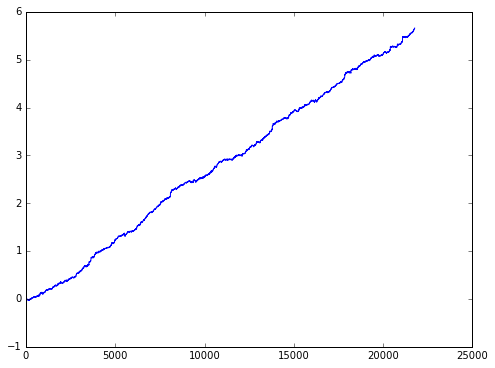

In [36]:
p_is = np.sign(y_is) * y_train_vals
p_os = np.sign(y_os) * y_test_vals
plt.plot(p_os.sum(axis=1).cumsum())

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

rgr = LinearRegression()
rgr.fit(x_train_vals, y_train_vals)
y_yhat_rgr_is = rgr.predict(x_train_vals)
y_yhat_rgr_os = rgr.predict(x_test_vals)

lis = mean_squared_error(y_train_vals, y_yhat_rgr_is) * 1e4
los = mean_squared_error(y_test_vals, y_yhat_rgr_os) * 1e4
print lis, los

0.0252049104977 0.0249484041414


In [ ]:
p_rgr_is = y_yhat_rgr_is * y_train_vals
p_rgr_os = y_yhat_rgr_os * y_test_vals
plt.plot(p_rgr_os.sum(axis=1).cumsum())
plt.plot(p_rgr_is.sum(axis=1).cumsum())

In [70]:
print p_rgr_is.mean() / p_rgr_is.std() * np.sqrt(60*24*360)
print p_rgr_os.mean() / p_rgr_os.std() * np.sqrt(60*24*360)

16.0470916701
10.8114249227


In [18]:
from yadlt.models.rbm_models import rbm
from yadlt.models.rnn_models import lstm

rbm_gauss = rbm.RBM(300, visible_unit_type='gauss')
rbm_gauss.fit(x_train.values, x_test.values)

enc_gauss_train = rbm_gauss.transform(x_train)
enc_gauss_test = rbm_gauss.transform(x_test)
rbm_gauss = rbm.RBM(60, visible_unit_type='bin')
rbm_gauss.fit(enc_gauss_train, enc_gauss_test)
enc_bin_train = rbm_gauss.transform(enc_gauss_train)
enc_bin_test = rbm_gauss.transform(enc_gauss_test)

# now try with classification

In [93]:
x_train_vals = x_train.astype(np.float32).values
y_train_vals = y_train.astype(np.float32).values
y_train_vals_sign = np.sign(y_train_vals + 1e-8)

x_test_vals = x_test.astype(np.float32).values
y_test_vals = y_test.astype(np.float32).values
y_test_vals_sign = np.sign(y_test_vals + 1e-8)


def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


num_hidden_1 = 200
#num_hidden_2 = 20

X = tf.placeholder("float")
y = tf.placeholder("float")

num_inputs = x_train.shape[1]
num_outs = y_train.shape[1]

print num_inputs, num_outs

W_1 = tf.Variable(tf.truncated_normal([num_inputs, num_hidden_1], stddev = 1.0/np.sqrt(num_inputs), name="weight1"))
W_2 = tf.Variable(tf.truncated_normal([num_hidden_1, num_outs], stddev = 1.0/np.sqrt(num_hidden_1), name="weight2"))
b_1 = tf.Variable(tf.truncated_normal([num_hidden_1,], stddev = 1e-4, name="bias"))
b_2 = tf.Variable(tf.truncated_normal([num_outs,], stddev = 1e-4, name="bias"))

hidden = tf.nn.relu(tf.add(tf.matmul(X, W_1), b_1))
#hidden = tf.add(tf.matmul(X, W_1), b_1)
hidden = tf.nn.dropout(hidden, keep_prob=0.85)

logits = tf.add(tf.matmul(hidden, W_2), b_2)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
                      
#loss = tf.reduce_sum(tf.pow(y - y_train_vals, 2)) 
#loss_p = tf.Print(loss, [loss], "loss: ")
optimizer = tf.train.GradientDescentOptimizer(0.00001).minimize(loss)
init = tf.initialize_all_variables()
#train = optimizer.minimize(loss)

32 4


In [ ]:
with tf.Session() as sess:
    sess.run(init)
    
    disp_step = 2500
    
    for i in range(50000):
        sess.run(optimizer, feed_dict={X : x_train_vals, y : y_train_vals})
        
        if i % disp_step == 0:
            print "Training iteration:", '%04d' % (i + 0), "cost=", "{:.9f}"\
            .format(sess.run(loss, feed_dict={X:x_train_vals, y:y_train_vals}))
            
            print "Testing iteration:", '%04d' % (i + 0), "cost=", "{:.9f}"\
            .format(sess.run(loss, feed_dict={X:x_test_vals, y:y_test_vals}))            
           
    w_mod = W_1.eval()
    b_mod = b_1.eval()
    #y_, _, preds_os = sess.run([optimizer, loss, y_model], feed_dict={X:x_train_vals, y:y_train_vals})
    y_is = y_model.eval(feed_dict={X:x_train_vals, y:y_train_vals})
    y_os = y_model.eval(feed_dict={X:x_test_vals, y:y_test_vals})
    
    #pred_out = sess.run()
    

In [12]:
x_train.shape

(65311, 72)

In [13]:
# now try use tflearn
from tensorflow.contrib.learn.python import learn as tfl
import tflearn

In [17]:
net = tflearn.input_data(shape=[None, 72])
net = tflearn.fully_connected(net, 25)
net = tflearn.fully_connected(net, 20)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net)
model = tflearn.DNN(net)

In [18]:
y_train_bool = pd.DataFrame(0, index=y_train.index, columns=["up", "down"])
y_train_bool['up'] = y_train > 0
y_train_bool['down'] =y_train < 0
#y_train_bool.filla(0)
conv = lambda x : 1 if x else 0
y_train_bool = y_train_bool.applymap(conv)

In [20]:

# Start training (apply gradient descent algorithm)
#model.fit(x_train.iloc[:-1].values, y_train_bool.shift(-1).iloc[:-1].values, n_epoch=5, batch_size=100, show_metric=True)

In [18]:
preds = model.predict(x_train.values)

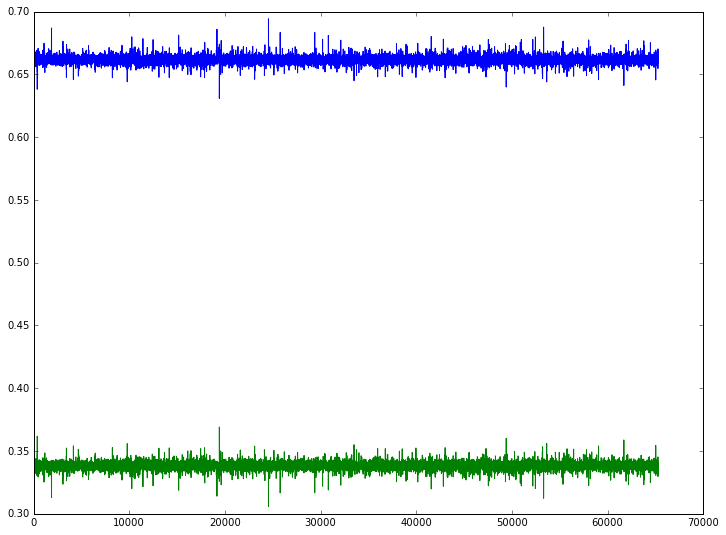

In [19]:
plt.plot(preds)

In [21]:
y_train_bool.sum()

up      43034
down    22277
dtype: int64

In [22]:
43034.0 / (43034.0 + 22277)

0.6589089127405797